
# Modelo CNN 1D  para Previsão de Tendência - VALE3.SA

**Objetivo:** Este notebook implementa e avalia um modelo de Rede Neural Convolucional 1D (CNN 1D) para prever a tendência (Compra/Venda) da ação VALE3.SA, utilizando a mesma base de dados e features dos modelos anteriores.

**Contexto:** Continuação do desafio da Cartesius Capital, utilizando a arquitetura CNN 1D com hiperparâmetros ajustados através do Keras Tuner para buscar o melhor desempenho.

**Metodologia:**
1.  **Carregamento e Pré-processamento:** Idênticos aos notebooks anteriores para comparabilidade.
2.  **Modelo CNN 1D :** Construção do modelo CNN 1D utilizando os **melhores hiperparâmetros** encontrados via Keras Tuner (detalhados na seção de construção do modelo).
3.  **Treinamento:** Treinamento do modelo com os mesmos dados, balanceamento de classes e Early Stopping.
4.  **Avaliação:** Análise detalhada do desempenho no conjunto de teste.
5.  **Visualização:** Geração de gráficos para análise.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
# Importa camadas específicas para CNN 1D
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam # Mantendo legacy Adam conforme necessidade (M1/M2 Macs)
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.utils import class_weight
import os

# Configurações básicas
plt.style.use('fivethirtyeight')
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)

# --- Configuração do Dispositivo ---
print("Configurando dispositivo TensorFlow...")
try:
    if tf.config.list_physical_devices('GPU'):
        print("GPU disponível. Usando TensorFlow com GPU.")
    elif hasattr(tf.config, 'list_physical_devices') and tf.config.list_physical_devices('MPS'):
         print("Apple MPS disponível. Usando TensorFlow com MPS.")
    else:
        print("Nenhuma GPU ou MPS detectada. Usando TensorFlow em CPU.")
except Exception as e:
    print(f"Erro ao configurar dispositivos: {e}. Usando configuração padrão.")

Configurando dispositivo TensorFlow...
GPU disponível. Usando TensorFlow com GPU.



## 1. Carregamento dos Dados

(Células de carregamento, engenharia de features, tratamento de NaNs, seleção de features, escalonamento e criação de sequências são idênticas às versões anteriores para manter a consistência.)

Carregamos os conjuntos de dados de treino e teste para VALE3.SA.


In [2]:
# Define o diretório dos dados e os caminhos para os arquivos
DATA_DIR = '../data/VALE3.SA/' # Certifique-se que este caminho está correto
TRAIN_PATH = os.path.join(DATA_DIR, 'treino.csv')
TEST_PATH = os.path.join(DATA_DIR, 'teste.csv')

# Tenta carregar os arquivos CSV
try:
    df_train_raw = pd.read_csv(TRAIN_PATH, index_col='Date', parse_dates=True)
    df_test_raw = pd.read_csv(TEST_PATH, index_col='Date', parse_dates=True)
    print(f"Dados de treino carregados. Shape: {df_train_raw.shape}")
    print(f"Dados de teste carregados. Shape: {df_test_raw.shape}")

    if 'Unnamed: 0' in df_train_raw.columns: df_train_raw = df_train_raw.drop(columns=['Unnamed: 0'])
    if 'Unnamed: 0' in df_test_raw.columns: df_test_raw = df_test_raw.drop(columns=['Unnamed: 0'])

    print("\n--- Amostra Dados Treino ---")
    print(df_train_raw.head())
    print("\n--- Amostra Dados Teste ---")
    print(df_test_raw.head())

except FileNotFoundError as e:
    print(f"Erro Crítico: Arquivo não encontrado. Verifique o caminho: {e}")
except Exception as e:
    print(f"Erro Crítico: Ocorreu um erro inesperado ao carregar os dados: {e}")

Dados de treino carregados. Shape: (4808, 19)
Dados de teste carregados. Shape: (1203, 19)

--- Amostra Dados Treino ---
               Close  Smoothed_Close  Label  Past_1_Days_Close  \
Date                                                             
2000-01-24  1.829122        1.752574      1           1.791015   
2000-01-25  1.829122        1.760229      1           1.829122   
2000-01-26  1.813879        1.765594      1           1.829122   
2000-01-27  1.829122        1.771947      1           1.813879   
2000-01-28  1.829122        1.777664      1           1.829122   

            Past_2_Days_Close  Past_3_Days_Close  Past_4_Days_Close  \
Date                                                                  
2000-01-24           1.829122           1.840554           1.848175   
2000-01-25           1.791015           1.829122           1.840554   
2000-01-26           1.829122           1.791015           1.829122   
2000-01-27           1.829122           1.829122           1.


## 2. Engenharia de Features e Definição do Alvo

Aplicamos a mesma função `calculate_features_and_target_adapted` para gerar os indicadores e a variável alvo `signal`.


In [3]:
def calculate_features_and_target_adapted(df):
    df_copy = df.copy(); price_col = 'Close'
    if price_col not in df_copy.columns: raise ValueError(f"Coluna '{price_col}' não encontrada.")
    if 'Label' not in df_copy.columns: raise ValueError("Coluna 'Label' (alvo) não encontrada.")
    df_copy['daily_return'] = df_copy[price_col].pct_change() * 100
    for window in [5, 10, 20, 50]: df_copy[f'sma_{window}'] = df_copy[price_col].rolling(window=window).mean()
    df_copy['ema_12'] = df_copy[price_col].ewm(span=12, adjust=False).mean(); df_copy['ema_26'] = df_copy[price_col].ewm(span=26, adjust=False).mean()
    df_copy['macd'] = df_copy['ema_12'] - df_copy['ema_26']; df_copy['macd_signal'] = df_copy['macd'].ewm(span=9, adjust=False).mean(); df_copy['macd_hist'] = df_copy['macd'] - df_copy['macd_signal']
    delta = df_copy[price_col].diff(); gain = delta.where(delta > 0, 0).fillna(0); loss = -delta.where(delta < 0, 0).fillna(0)
    avg_gain = gain.ewm(com=14 - 1, min_periods=14).mean(); avg_loss = loss.ewm(com=14 - 1, min_periods=14).mean()
    rs = avg_gain / avg_loss; df_copy['rsi'] = 100 - (100 / (1 + rs)); df_copy['rsi'] = df_copy['rsi'].fillna(50)
    for window in [5, 10, 20]: df_copy[f'roc_{window}'] = df_copy[price_col].pct_change(periods=window) * 100
    past_cols = [col for col in df_copy.columns if col.startswith('Past_') and col.endswith('_Close')]
    for col in past_cols:
        try: df_copy[f'return_{col}'] = (df_copy[price_col] / df_copy[col] - 1) * 100; df_copy[f'return_{col}'] = df_copy[f'return_{col}'].replace([np.inf, -np.inf], np.nan)
        except Exception as e: print(f"Aviso: Não foi possível calcular retorno para {col}. Erro: {e}")
    if df_copy['Label'].isin([1, -1]).all(): df_copy['signal'] = df_copy['Label'].map({1: 1, -1: 0})
    elif df_copy['Label'].isin([1, 0]).all(): df_copy['signal'] = df_copy['Label']
    elif df_copy['Label'].isin(['buy', 'sell']).all(): df_copy['signal'] = df_copy['Label'].map({'buy': 1, 'sell': 0})
    else: raise ValueError(f"Valores inesperados na coluna 'Label': {df_copy['Label'].unique()}.")
    if 'Label' in df_copy.columns: df_copy = df_copy.drop(columns=['Label'])
    return df_copy

print("Aplicando engenharia de features...")
df_train_processed = calculate_features_and_target_adapted(df_train_raw)
df_test_processed = calculate_features_and_target_adapted(df_test_raw)
print("Engenharia de features concluída.")

Aplicando engenharia de features...
Engenharia de features concluída.



## 3. Tratamento de Valores Ausentes (NaNs)

Remoção de linhas com NaNs após o cálculo das features.


In [4]:
print("Iniciando tratamento de NaNs...")
initial_train_rows = len(df_train_processed); initial_test_rows = len(df_test_processed)
return_past_cols = [col for col in df_train_processed.columns if col.startswith('return_Past_')]
if return_past_cols:
    df_train_processed[return_past_cols] = df_train_processed[return_past_cols].fillna(0)
    df_test_processed[return_past_cols] = df_test_processed[return_past_cols].fillna(0)
df_train_processed.dropna(inplace=True); df_test_processed.dropna(inplace=True)
print(f"Linhas removidas do treino: {initial_train_rows - len(df_train_processed)}, teste: {initial_test_rows - len(df_test_processed)}")
print(f"Shape treino final: {df_train_processed.shape}, teste: {df_test_processed.shape}")
if df_train_processed.empty or df_test_processed.empty: raise RuntimeError("Erro: DataFrames vazios.")
if 'signal' in df_train_processed.columns:
    df_train_processed['signal'] = df_train_processed['signal'].astype(int)
    df_test_processed['signal'] = df_test_processed['signal'].astype(int)
else: raise ValueError("Erro: Coluna 'signal' não encontrada.")
print("Tratamento de NaNs concluído.")

Iniciando tratamento de NaNs...
Linhas removidas do treino: 49, teste: 49
Shape treino final: (4759, 47), teste: (1154, 47)
Tratamento de NaNs concluído.



## 4. Seleção de Features e Preparação Final

Seleção da mesma lista de features e separação dos dados em X/y.


In [5]:
feature_cols = [
    'daily_return', 'sma_5', 'sma_10', 'sma_20', 'sma_50', 'ema_12', 'ema_26',
    'macd', 'macd_signal', 'macd_hist', 'rsi', 'roc_5', 'roc_10', 'roc_20',
    'return_Past_1_Days_Close', 'return_Past_3_Days_Close', 'return_Past_5_Days_Close',
    'return_Past_10_Days_Close', 'return_Past_15_Days_Close', 'Close'
]
target_col = 'signal'
available_train_cols=df_train_processed.columns.tolist(); available_test_cols=df_test_processed.columns.tolist()
feature_cols = sorted(list(set([col for col in feature_cols if col in available_train_cols and col in available_test_cols])))
missing_train = [col for col in feature_cols if col not in available_train_cols]; missing_test = [col for col in feature_cols if col not in available_test_cols]
if missing_train: raise ValueError(f"ERRO: Features faltando no treino: {missing_train}")
if missing_test: raise ValueError(f"ERRO: Features faltando no teste: {missing_test}")
print(f"Features finais selecionadas ({len(feature_cols)}).")
X_train = df_train_processed[feature_cols]; y_train = df_train_processed[target_col]
X_test = df_test_processed[feature_cols]; y_test = df_test_processed[target_col]
print(f"Shapes: X_train {X_train.shape}, y_train {y_train.shape}, X_test {X_test.shape}, y_test {y_test.shape}")

Features finais selecionadas (20).
Shapes: X_train (4759, 20), y_train (4759,), X_test (1154, 20), y_test (1154,)



## 5. Pré-processamento: Escalonamento

Aplicação do `MinMaxScaler`.


In [6]:
print("Aplicando escalonamento MinMaxScaler...")
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Escalonamento concluído.")

Aplicando escalonamento MinMaxScaler...
Escalonamento concluído.



## 6. Pré-processamento: Criação de Sequências Temporais

Criação das sequências de `n_steps = 15`.


In [7]:
def create_sequences(X, y, n_steps):
    if len(X) < n_steps:
        n_features = X.shape[1] if X.ndim == 2 else 0
        return np.empty((0, n_steps, n_features)), np.empty((0,)), np.empty((0,), dtype=y.index.dtype)
    Xs, ys, y_indices = [], [], []
    for i in range(len(X) - n_steps + 1):
        end_ix = i + n_steps; Xs.append(X[i:end_ix]); ys.append(y.iloc[end_ix - 1]); y_indices.append(y.index[end_ix - 1])
    if not Xs:
        n_features = X.shape[1] if X.ndim == 2 else 0
        return np.empty((0, n_steps, n_features)), np.empty((0,)), np.empty((0,), dtype=y.index.dtype)
    return np.array(Xs), np.array(ys), np.array(y_indices)

n_steps = 15
print(f"Criando sequências com n_steps = {n_steps}...")
X_train_seq, y_train_seq, _ = create_sequences(X_train_scaled, y_train, n_steps)
X_test_seq, y_test_seq, y_test_indices = create_sequences(X_test_scaled, y_test, n_steps)
if X_train_seq.size == 0 or X_test_seq.size == 0: raise RuntimeError("Erro: Não foi possível criar as sequências.")
print(f"Shapes: X_train_seq {X_train_seq.shape}, y_train_seq {y_train_seq.shape}, X_test_seq {X_test_seq.shape}, y_test_seq {y_test_seq.shape}")

Criando sequências com n_steps = 15...
Shapes: X_train_seq (4745, 15, 20), y_train_seq (4745,), X_test_seq (1140, 15, 20), y_test_seq (1140,)



## 7. Balanceamento de Classes

Cálculo dos pesos de classe.


In [8]:
print("Calculando pesos das classes...")
if len(y_train_seq) > 0 and len(np.unique(y_train_seq)) > 1:
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_seq), y=y_train_seq)
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    print(f"Pesos das classes calculados: {class_weight_dict}")
else:
    print("Aviso: Não foi possível calcular pesos."); class_weight_dict = None

Calculando pesos das classes...
Pesos das classes calculados: {0: 0.8879116766467066, 1: 1.1444766039556198}



## 8. Construção do Modelo CNN 1D 

Construímos o modelo CNN 1D utilizando a biblioteca Keras e os **melhores hiperparâmetros encontrados** através da busca com Keras Tuner:

* **Número de Filtros (Camada 1):** 64
* **Tamanho do Kernel:** 3
* **Segunda Camada Conv1D:** Sim (64 filtros)
* **Tipo de Pooling:** MaxPooling1D (`pool_size=2`)
* **Camada Densa Intermediária:** Sim (96 unidades)
* **Taxa de Dropout:** 0.3
* **Taxa de Aprendizado (Adam Legacy):** 0.0009

A arquitetura resultante é:
`Conv1D(64, 3) -> Conv1D(64, 3) -> MaxPooling1D(2) -> Flatten -> Dense(96) -> Dropout(0.2) -> Dense(1, sigmoid)`


In [24]:
print("Construindo o modelo CNN 1D com hiperparâmetros otimizados...")

if X_train_seq.size > 0:
    n_features = X_train_seq.shape[2]
    print(f"Número de features de entrada: {n_features}")

    # --- Hiperparâmetros  (do tuning CNN 1D) ---
    HP_FILTERS_1 = 64
    HP_KERNEL_SIZE = 3
    HP_ADD_CONV2 = True # Adicionar segunda camada
    HP_FILTERS_2 = 64
    HP_POOLING_TYPE = 'max' # Usar MaxPooling
    HP_DROPOUT_CNN = 0.3
    HP_ADD_DENSE = True # Adicionar camada densa intermediária
    HP_DENSE_UNITS = 96
    HP_LEARNING_RATE = 0.0009 # Melhor LR encontrada

    model = Sequential(name="CNN_1D_Otimizado_VALE3")

    # Camada Convolucional 1
    model.add(Conv1D(filters=HP_FILTERS_1,
                     kernel_size=HP_KERNEL_SIZE,
                     activation='relu',
                     padding='same', # Usar padding='same'
                     input_shape=(n_steps, n_features),
                     name='conv1d_layer_1'))

    # Camada Convolucional 2 (se HP_ADD_CONV2 for True)
    if HP_ADD_CONV2:
        model.add(Conv1D(filters=HP_FILTERS_2,
                         kernel_size=HP_KERNEL_SIZE,
                         activation='relu',
                         padding='same',
                         name='conv1d_layer_2'))

    # Camada de Pooling (MaxPooling1D neste caso)
    if HP_POOLING_TYPE == 'max':
        model.add(MaxPooling1D(pool_size=2, name='maxpooling1d_layer'))
        # Flatten necessário após MaxPooling
        model.add(Flatten(name='flatten_layer'))
    elif HP_POOLING_TYPE == 'global_max':
         # GlobalMaxPooling não foi o melhor no tuning, mas o código estaria aqui
         model.add(GlobalMaxPooling1D(name='globalmaxpooling1d_layer'))
         # Flatten não é necessário após GlobalMaxPooling
    else:
        # Fallback ou erro se pooling_type for inválido
        raise ValueError(f"Tipo de pooling inválido: {HP_POOLING_TYPE}")


    # Camada Densa Intermediária (se HP_ADD_DENSE for True)
    if HP_ADD_DENSE:
        model.add(Dense(units=HP_DENSE_UNITS, activation='relu', name='dense_intermediate'))

    # Dropout
    model.add(Dropout(HP_DROPOUT_CNN, name='dropout_cnn_tuned'))

    # Camada de Saída
    model.add(Dense(1, activation='sigmoid', name='output_layer'))

    model.summary() # Exibe a arquitetura final

else:
    raise RuntimeError("Erro: X_train_seq está vazio, não é possível construir o modelo.")

print("\nCompilando o modelo CNN 1D")
# Compila o modelo com o otimizador e taxa de aprendizado otimizados
model.compile(
    optimizer=LegacyAdam(learning_rate=HP_LEARNING_RATE), # Usando LegacyAdam e LR otimizada
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)
print("Modelo CNN 1D compilado com sucesso.")

Construindo o modelo CNN 1D com hiperparâmetros otimizados...
Número de features de entrada: 20
Model: "CNN_1D_VALE3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_layer_1 (Conv1D)     (None, 15, 64)            3904      
                                                                 
 conv1d_layer_2 (Conv1D)     (None, 15, 64)            12352     
                                                                 
 maxpooling1d_layer (MaxPoo  (None, 7, 64)             0         
 ling1D)                                                         
                                                                 
 flatten_layer (Flatten)     (None, 448)               0         
                                                                 
 dense_intermediate (Dense)  (None, 96)                43104     
                                                                 
 dropout_cnn_tuned (Drop


## 9. Treinamento do Modelo CNN 1D 

Treinamos o modelo CNN 1D com a arquitetura e hiperparâmetros otimizados.


In [27]:
# Parâmetros de treinamento
EPOCHS = 60 # Pode aumentar um pouco as épocas para o modelo final
BATCH_SIZE = 64

# Configuração do Early Stopping
early_stopping = EarlyStopping(
    monitor='val_auc', patience=10, mode='max', # Pode aumentar a paciência
    restore_best_weights=True, verbose=1
)

print(f"Iniciando o treinamento do CNN 1D  por até {EPOCHS} épocas...")

# Treina o modelo CNN 1D
history_cnn_opt = model.fit( # Nome diferente para o histórico
    X_train_seq,
    y_train_seq,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=[early_stopping],
    class_weight=class_weight_dict,
    verbose=1
)

print("Treinamento do CNN 1D  concluído.")

Iniciando o treinamento do CNN 1D  por até 60 épocas...
Epoch 1/60
75/75 [==============================] - 1s 10ms/step - loss: 0.0611 - accuracy: 0.9718 - auc: 0.9977 - val_loss: 0.1253 - val_accuracy: 0.9456 - val_auc: 0.9918
Epoch 2/60
75/75 [==============================] - 1s 9ms/step - loss: 0.0475 - accuracy: 0.9802 - auc: 0.9987 - val_loss: 0.2711 - val_accuracy: 0.9149 - val_auc: 0.9766
Epoch 3/60
75/75 [==============================] - 1s 9ms/step - loss: 0.0730 - accuracy: 0.9680 - auc: 0.9966 - val_loss: 0.2976 - val_accuracy: 0.9044 - val_auc: 0.9738
Epoch 4/60
75/75 [==============================] - 1s 9ms/step - loss: 0.0834 - accuracy: 0.9667 - auc: 0.9956 - val_loss: 0.2266 - val_accuracy: 0.9167 - val_auc: 0.9796
Epoch 5/60
75/75 [==============================] - 1s 10ms/step - loss: 0.0887 - accuracy: 0.9638 - auc: 0.9952 - val_loss: 0.1552 - val_accuracy: 0.9307 - val_auc: 0.9869
Epoch 6/60
75/75 [==============================] - 1s 9ms/step - loss: 0.0458 - a


## 10. Avaliação do Desempenho (CNN 1D )

Avaliamos o modelo CNN 1D no conjunto de teste.


Avaliando o modelo CNN 1D  no conjunto de teste...

--- Resultados da Avaliação CNN 1D  (evaluate) ---
Perda (Loss): 0.1253
Acurácia: 0.9456 (94.56%)
AUC (da evaluate): 0.9918

Gerando previsões CNN 1D  no conjunto de teste...
Usando limiar padrão: 0.50 para classificação.

--- Matriz de Confusão (CNN 1D ) ---


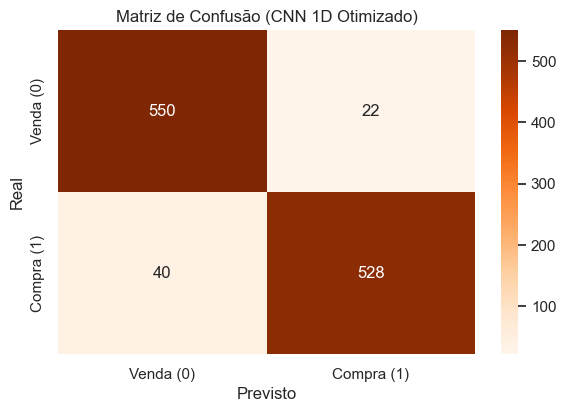


--- Relatório de Classificação (CNN 1D ) ---
              precision    recall  f1-score   support

   Venda (0)       0.93      0.96      0.95       572
  Compra (1)       0.96      0.93      0.94       568

    accuracy                           0.95      1140
   macro avg       0.95      0.95      0.95      1140
weighted avg       0.95      0.95      0.95      1140


--- AUC Score (CNN 1D ) ---
AUC Score (calculado): 0.9917


In [28]:
print("Avaliando o modelo CNN 1D  no conjunto de teste...")

# Avalia o modelo
results_cnn_opt = model.evaluate(X_test_seq, y_test_seq, verbose=0, batch_size=BATCH_SIZE*2)
loss_cnn_opt = results_cnn_opt[0]
accuracy_cnn_opt = results_cnn_opt[1]
auc_metric_cnn_opt = results_cnn_opt[2]

print(f"\n--- Resultados da Avaliação CNN 1D  (evaluate) ---")
print(f"Perda (Loss): {loss_cnn_opt:.4f}")
print(f"Acurácia: {accuracy_cnn_opt:.4f} ({accuracy_cnn_opt*100:.2f}%)")
print(f"AUC (da evaluate): {auc_metric_cnn_opt:.4f}")

# Gera previsões
print("\nGerando previsões CNN 1D  no conjunto de teste...")
y_pred_proba_cnn_opt = model.predict(X_test_seq, batch_size=BATCH_SIZE*2, verbose=0).flatten()

# Converte probabilidades em classes
threshold = 0.5
y_pred_cnn_opt = (y_pred_proba_cnn_opt >= threshold).astype(int)
print(f"Usando limiar padrão: {threshold:.2f} para classificação.")

# Criar DataFrame com resultados
results_df_cnn_opt = pd.DataFrame({
    'Actual': y_test_seq, 'Predicted': y_pred_cnn_opt, 'Probability': y_pred_proba_cnn_opt
}, index=y_test_indices)
plot_df_cnn_opt = df_test_processed.loc[results_df_cnn_opt.index].copy().join(results_df_cnn_opt)

# Matriz de Confusão
print("\n--- Matriz de Confusão (CNN 1D ) ---")
cm_cnn_opt = confusion_matrix(y_test_seq, y_pred_cnn_opt)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_cnn_opt, annot=True, fmt='d', cmap='Oranges', xticklabels=['Venda (0)', 'Compra (1)'], yticklabels=['Venda (0)', 'Compra (1)']) # Cor diferente
plt.xlabel('Previsto'); plt.ylabel('Real'); plt.title('Matriz de Confusão (CNN 1D )')
plt.show()

# Relatório de Classificação
print("\n--- Relatório de Classificação (CNN 1D ) ---")
report_cnn_opt = classification_report(y_test_seq, y_pred_cnn_opt, target_names=['Venda (0)', 'Compra (1)'], zero_division=0)
print(report_cnn_opt)

# AUC Score
print("\n--- AUC Score (CNN 1D ) ---")
try:
    roc_auc_score_cnn_opt = roc_auc_score(y_test_seq, y_pred_proba_cnn_opt)
    print(f"AUC Score (calculado): {roc_auc_score_cnn_opt:.4f}")
except ValueError as e: print(f"Não foi possível calcular AUC score: {e}")
except Exception as e: print(f"Erro ao calcular AUC Score: {e}")


## 11. Visualização dos Resultados (CNN 1D )

Visualização do desempenho do modelo CNN 1D.


Gerando gráficos de visualização para CNN 1D ...
Plotando histórico de treinamento CNN 1D ...


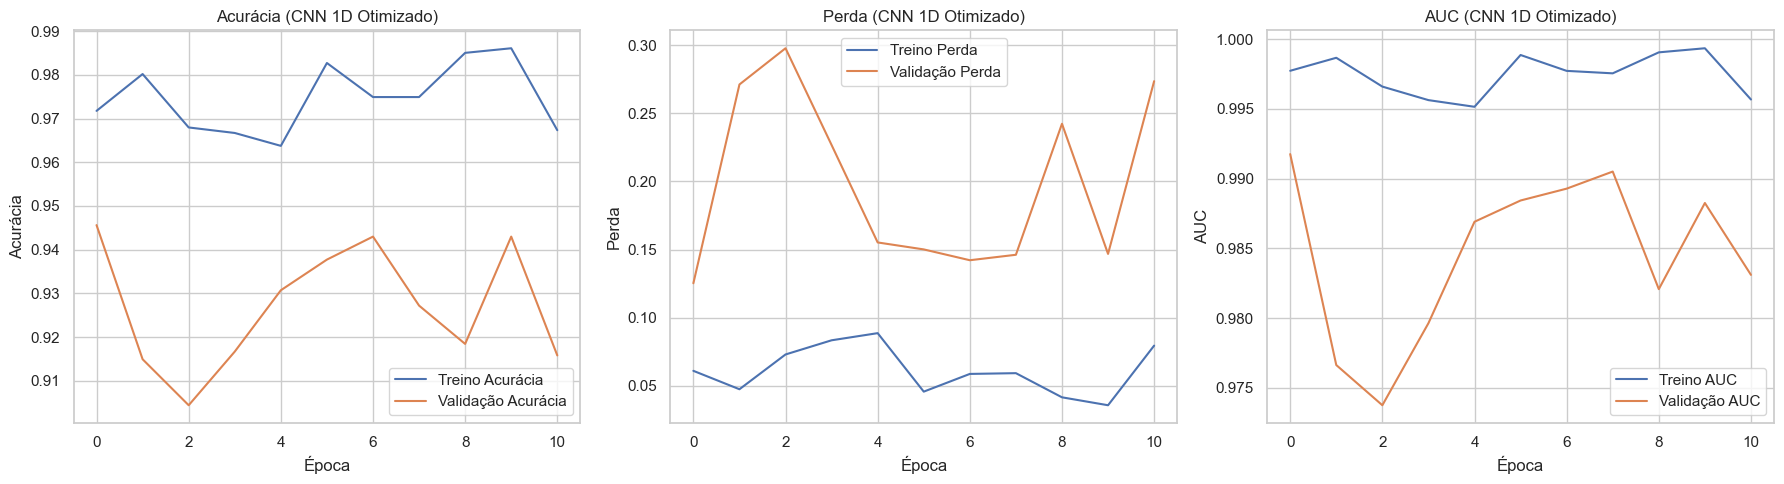

Plotando Curva ROC (CNN 1D )...


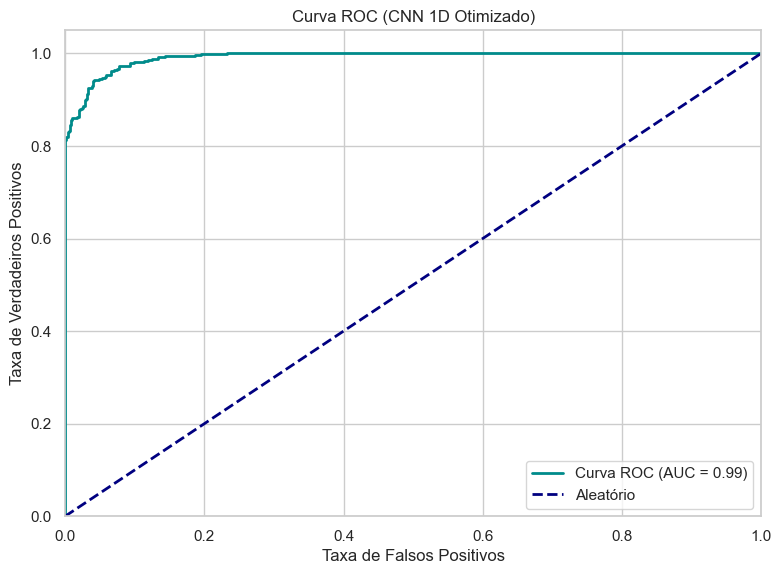

Plotando distribuição das probabilidades (CNN 1D )...


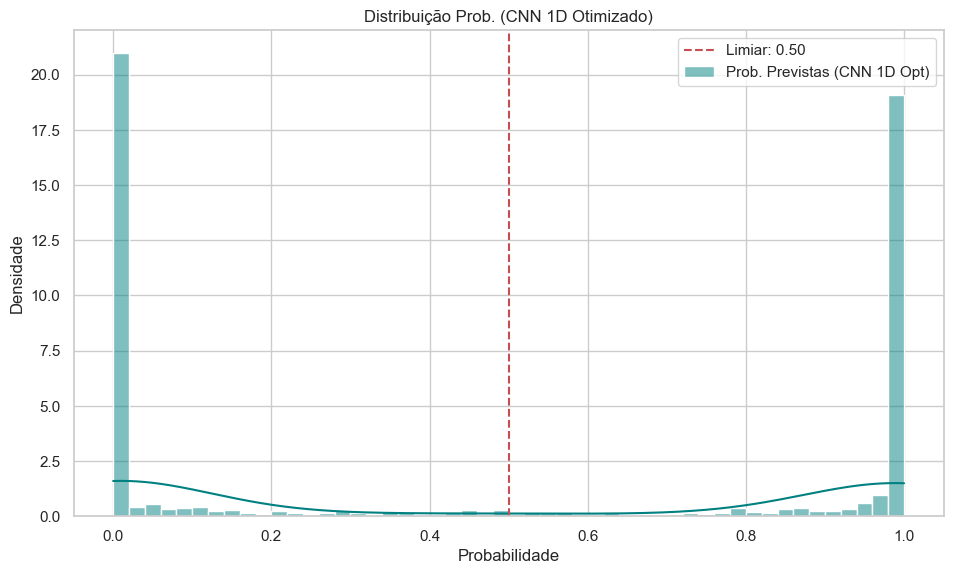

Plotando gráfico de Preço vs. Sinais Previstos (CNN 1D )...


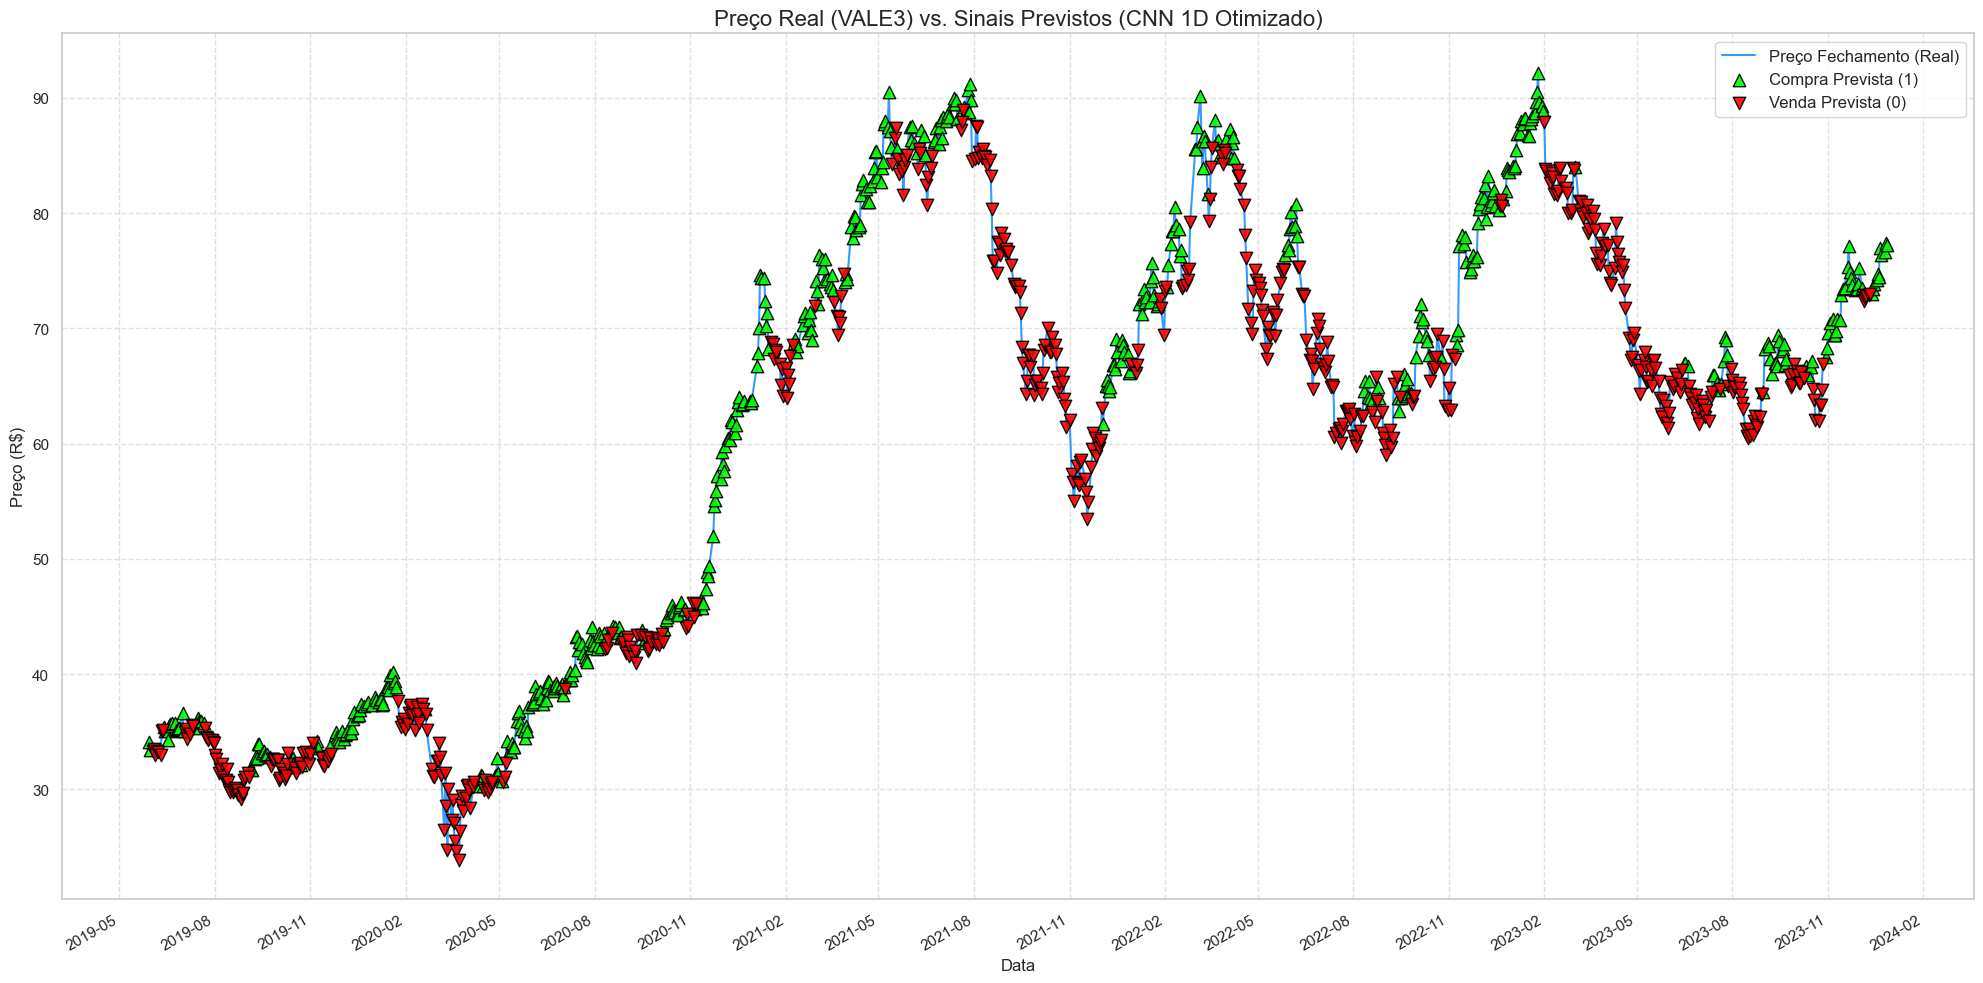

In [29]:
print("Gerando gráficos de visualização para CNN 1D ...")

# 1. Gráficos do Histórico de Treinamento
if 'history_cnn_opt' in locals() and history_cnn_opt.history:
    print("Plotando histórico de treinamento CNN 1D ...")
    plt.figure(figsize=(18, 5))
    metrics_to_plot={'Acurácia':'accuracy','Perda':'loss','AUC':'auc'}
    i=1
    for display_name, metric_key in metrics_to_plot.items():
        if metric_key in history_cnn_opt.history:
            plt.subplot(1,len(metrics_to_plot), i)
            plt.plot(history_cnn_opt.history[metric_key],label=f'Treino {display_name}')
            val_metric_key=f'val_{metric_key}'
            if val_metric_key in history_cnn_opt.history:
                plt.plot(history_cnn_opt.history[val_metric_key],label=f'Validação {display_name}')
            plt.title(f'{display_name} (CNN 1D )'); plt.xlabel('Época'); plt.ylabel(display_name); plt.legend(); i+=1
    plt.tight_layout(); plt.savefig('cnn1d_opt_vale3_training_metrics.png'); plt.show()
else: print("Histórico de treinamento não disponível.")

# 2. Gráfico da Curva ROC
if len(np.unique(y_test_seq)) > 1:
    print("Plotando Curva ROC (CNN 1D )...")
    plt.figure(figsize=(8, 6))
    try:
        fpr_cnn_opt, tpr_cnn_opt, _ = roc_curve(y_test_seq, y_pred_proba_cnn_opt)
        roc_auc_cnn_opt = auc(fpr_cnn_opt, tpr_cnn_opt)
        plt.plot(fpr_cnn_opt, tpr_cnn_opt, color='darkcyan', lw=2, label=f'Curva ROC (AUC = {roc_auc_cnn_opt:.2f})') # Cor diferente
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatório')
        plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05]); plt.xlabel('Taxa de Falsos Positivos'); plt.ylabel('Taxa de Verdadeiros Positivos')
        plt.title('Curva ROC (CNN 1D )'); plt.legend(loc="lower right"); plt.grid(True); plt.savefig('cnn1d_opt_vale3_roc_curve.png'); plt.show()
    except Exception as e: print(f"Erro ao gerar curva ROC: {e}")
else: print("Curva ROC não gerada.")

# 3. Gráfico da Distribuição das Probabilidades
print("Plotando distribuição das probabilidades (CNN 1D )...")
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_proba_cnn_opt, bins=50, kde=True, label='Prob. Previstas (CNN 1D Opt)', color='teal', stat='density') # Cor diferente
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Limiar: {threshold:.2f}'); plt.title('Distribuição Prob. (CNN 1D )')
plt.xlabel('Probabilidade'); plt.ylabel('Densidade'); plt.legend(); plt.savefig('cnn1d_opt_vale3_prediction_distribution.png'); plt.show()

# 4. Gráfico de Preço Real vs. Sinais Previstos
print("Plotando gráfico de Preço vs. Sinais Previstos (CNN 1D )...")
plt.figure(figsize=(20, 10))
plt.plot(plot_df_cnn_opt.index, plot_df_cnn_opt['Close'], label='Preço Fechamento (Real)', color='dodgerblue', alpha=0.9, lw=1.5, zorder=1)
buy_sig_opt = plot_df_cnn_opt[plot_df_cnn_opt['Predicted'] == 1]; sell_sig_opt = plot_df_cnn_opt[plot_df_cnn_opt['Predicted'] == 0]
plt.scatter(buy_sig_opt.index, buy_sig_opt['Close'], label='Compra Prevista (1)', marker='^', color='lime', s=80, ec='black', alpha=0.9, zorder=3)
plt.scatter(sell_sig_opt.index, sell_sig_opt['Close'], label='Venda Prevista (0)', marker='v', color='red', s=80, ec='black', alpha=0.9, zorder=3)
plt.title('Preço Real (VALE3) vs. Sinais Previstos (CNN 1D )', fontsize=16); plt.xlabel('Data', fontsize=12); plt.ylabel('Preço (R$)', fontsize=12)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')); plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate(); plt.legend(fontsize=12); plt.grid(True, linestyle='--', alpha=0.6); plt.tight_layout()
plt.savefig('cnn1d_opt_vale3_price_vs_predictions.png'); plt.show()


## 12. Salvamento do Modelo (CNN 1D)

Salvamos o modelo CNN 1D.


In [30]:
print("Salvando o modelo CNN 1D  treinado...")
MODEL_SAVE_PATH_CNN_OPT = 'models/vale3_cnn1d_model.keras' # Nome do arquivo diferente
H5_SAVE_PATH_CNN_OPT = 'models/vale3_cnn1d_model.h5' # Nome do arquivo diferente

try:
    os.makedirs('models', exist_ok=True)
    model.save(MODEL_SAVE_PATH_CNN_OPT)
    print(f"Modelo CNN 1D  salvo com sucesso em '{MODEL_SAVE_PATH_CNN_OPT}'")
except Exception as e:
    print(f"Erro ao salvar o modelo CNN 1D  no formato Keras: {e}")
    try:
        model.save(H5_SAVE_PATH_CNN_OPT)
        print(f"Modelo CNN 1D  salvo no formato HDF5 em '{H5_SAVE_PATH_CNN_OPT}'")
    except Exception as e2:
        print(f"Erro ao salvar o modelo CNN 1D  no formato HDF5: {e2}")

Salvando o modelo CNN 1D  treinado...
Modelo CNN 1D  salvo com sucesso em 'models/vale3_cnn1d_model.keras'
